In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gtsrb-german-traffic-sign/Meta.csv
/kaggle/input/gtsrb-german-traffic-sign/Train.csv
/kaggle/input/gtsrb-german-traffic-sign/Test.csv
/kaggle/input/gtsrb-german-traffic-sign/Meta/37.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/35.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/11.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/31.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/4.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/40.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/33.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/9.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/.~lock.ClassesInformation.ods#
/kaggle/input/gtsrb-german-traffic-sign/Meta/14.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/1.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/39.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/20.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/38.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/2.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/10.png


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import *

# **Assigning Path for Dataset**

In [ ]:
data = []
labels = []
classes = 43
cur_path = '../input/gtsrb-german-traffic-sign/Train'

for i in os.listdir(cur_path):
    dir = cur_path + '/' + i
    for j in os.listdir(dir):
        img_path = dir+'/'+j
        img = cv2.imread(img_path,-1)
        img = cv2.resize(img, (30,30), interpolation = cv2.INTER_NEAREST)
        data.append(img)
        labels.append(i)
        
x_train = np.array(data)
x_train = x_train / 255
y_train = np.array(labels).astype(np.float)

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

In [ ]:
np.unique(labels).shape

In [ ]:
i_path = '../input/gtsrb-german-traffic-sign/Train/1/00001_00072_00027.png'
plt.imshow(cv2.imread(i_path, -1))

# Visualizing The Dataset

In [ ]:
data_dic = {}
for folder in os.listdir(cur_path):
    data_dic[folder] = len(os.listdir(cur_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Classes')
plt.ylabel('Number of images')

# Making the model

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = 'relu', 
                 input_shape = (30, 30, 3), data_format = 'channels_last',
                 kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-3)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = "same", strides = (2, 2),
                kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-3)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 128, kernel_size = (5,5), activation = 'relu' ,
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (5,5), padding = "same",
                 kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-3), strides = (2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(1024, activation = 'relu',  kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
model.add(Dropout(0.4))
model.add(Dense(256, activation = 'relu',  kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
model.add(Dropout(0.5))
model.add(Dense(43, activation = 'softmax',  kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
model.summary()

# training the model

In [11]:
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer = opt,
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train ,y_train,  batch_size = 128, 
         epochs=2, validation_data = (x_valid, y_valid),
          callbacks=[callback, reduce_lr], shuffle = True)

Epoch 1/2
197/197 [==============================] - 90s 447ms/step - loss: 7.6489 - accuracy: 0.7691 - val_loss: 6.8091 - val_accuracy: 0.3658
Epoch 2/2
197/197 [==============================] - 87s 444ms/step - loss: 3.5531 - accuracy: 0.8887 - val_loss: 4.2691 - val_accuracy: 0.5242


# Evaluating the model

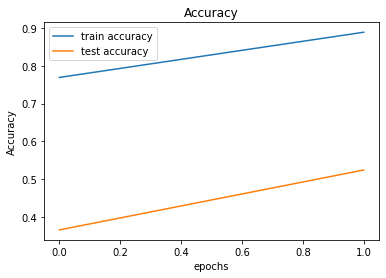

In [12]:
plt.figure(0)
plt.plot(history.history['accuracy'], label= 'train accuracy')
plt.plot(history.history['val_accuracy'], label= 'test accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()


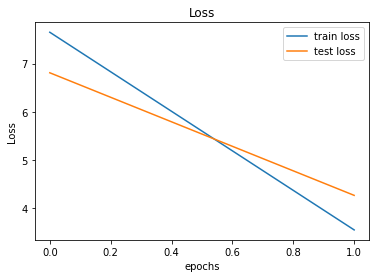

In [13]:
plt.figure(0)
plt.plot(history.history['loss'], label= 'train loss')
plt.plot(history.history['val_loss'], label= 'test loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# random images from test data

In [14]:

test = pd.read_csv('../input/gtsrb-german-traffic-sign/Test.csv')
y_test = test["ClassId"].values
imgs = test["Path"].values
data =[]
for img in imgs:
    image = cv2.imread('../input/gtsrb-german-traffic-sign/' +img)
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((30, 30))
    data.append(np.array( resize_image ))

x_test = np.array(data)
x_test = x_test/255
model.evaluate(x_test, y_test)

395/395 [==============================] - 16s 39ms/step - loss: 4.3641 - accuracy: 0.5001


[4.36409330368042, 0.5000791549682617]

In [19]:
dic = {0 : '20 speed limit', 1 : '30 speed limit', 2 : '50 speed limit', 3 : '60 speed limit', 4 : '70 speed limit', 5 : '80 speed limit', 6 : 'do not cross 80'}

# Predictions on Test Data

In [21]:
def predictImage(image_path):
    image = cv2.imread(image_path, -1)
    plt.imshow(image)
    plt.show()
    image = cv2.resize(image, (30,30), interpolation = cv2.INTER_NEAREST)
    image = image.reshape((1,30,30,3))
    prediction = model.predict(image)[0]
    predicted_class = np.argmax(prediction)
    pred_prob = max(prediction)
    return dic[predicted_class]

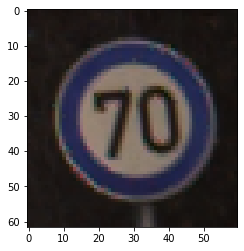

'70 speed limit'

In [22]:
predictImage("../input/gtsrb-german-traffic-sign/Test/00390.png")

In [23]:
model.save('model.h5')